In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import GLSAR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_percentage_error
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
df_raw = pd.read_csv('dataset_lm.csv')
df_raw

,Dependent Var,Explanatory Var #1,Explanatory Var #2,Explanatory Var #3,Explanatory Var #4,Explanatory Var #5,Explanatory Var #6,Explanatory Var #7,Explanatory Var #8,Explanatory Var #9,Explanatory Var #10,Explanatory Var #11,Explanatory Var #12,Explanatory Var #13,Explanatory Var #14,Explanatory Var #15
0,56.293458,13.698667,50.639873,0,-18.568035,45.121911,11.412501,56.410757,2,-12.281132,38.996909,-3.010548,49.195073,0,-21.153143,46.919314
1,58.473431,2.714725,65.845845,1,-25.105932,47.190213,10.080280,65.383107,3,-36.763585,51.654939,4.991111,45.591729,0,-6.474403,53.383508
2,94.195330,11.618072,65.072497,0,-7.897464,52.163036,11.057301,82.812717,0,-15.733547,48.913837,-2.457696,56.608806,0,-27.903299,48.515026
3,29.074583,0.818623,45.408996,1,-18.316132,54.356714,5.029029,48.812471,1,-12.825591,45.851732,14.974177,47.362594,1,-10.064411,55.266254
4,86.035569,9.077544,73.548021,0,-19.204165,47.186807,12.128134,62.520911,2,-13.804860,47.765904,9.593982,53.700562,0,-17.546302,48.150543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,61.300432,0.338441,70.430598,0,-21.525979,50.741115,-8.050843,39.075397,3,-29.197173,57.473862,15.505202,73.280605,1,-3.602482,56.317474
418,26.309237,-1.729712,47.087996,1,-19.034807,55.242929,28.001769,76.429649,0,-21.941401,54.641620,14.295688,49.816798,1,-13.910494,52.827988
419,58.350627,18.322301,53.267835,0,-26.186201,36.702958,14.530116,51.275150,2,-20.699670,46.443687,5.708762,52.751016,1,-6.202345,52.467289
420,31.954003,0.436357,61.844132,0,-25.881961,57.106851,21.786066,68.928442,0,-23.166461,59.194840,8.365762,64.291056,1,-21.330017,50.237673


In [9]:

# 2) Sanitize column names
#    (Patsy formulas dislike spaces/#/punctuation/leading digits)
# -------------------------------
def sanitize_colname(name: str) -> str:
    s = re.sub(r'\W', '_', str(name))       # non-alphanumeric -> underscore
    s = re.sub(r'_+', '_', s).strip('_')    # collapse repeats & trim edges
    if re.match(r'^\d', s):                 # if starts with a digit, prefix
        s = "f_" + s
    return s or "col"

orig_cols = list(df_raw.columns)
safe_cols = [sanitize_colname(c) for c in orig_cols]
rename_map = dict(zip(orig_cols, safe_cols))
df = df_raw.rename(columns=rename_map).copy()
reverse_map = {v: k for k, v in rename_map.items()}

print("Sanitized names (original -> safe):")
print(rename_map, "\n")

# -------------------------------
# 3) Pick dependent variable
# -------------------------------
if "Dependent_Var" in df.columns:
    y_name = "Dependent_Var"
    reason = "User dataset expected target 'Dependent Var' (sanitized to 'Dependent_Var')."
else:
    # fallback heuristic
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    y_name = None
    for c in num_cols:
        if df[c].nunique(dropna=True) >= 8:
            y_name = c
            break
    if y_name is None and num_cols:
        y_name = num_cols[0]
    if y_name is None:
        raise ValueError("No numeric column found to use as dependent variable (Y).")
    reason = f"Chose a numeric column with sufficient variation: {reverse_map.get(y_name, y_name)}"

print(f"Chosen Y: {reverse_map.get(y_name, y_name)}  -- {reason}")

# -------------------------------
# 4) Build formula with ALL remaining columns as X
#    - numeric features enter directly
#    - object/bool features are wrapped by C(...) to create dummies
#    - NO identifier filtering here; keep all X except Y
# -------------------------------
X_all = [c for c in df.columns if c != y_name]

# Determine which X are categorical-like (object/bool/categorical)
def is_categorical_like(series: pd.Series) -> bool:
    return (
        series.dtype == "object"
        or isinstance(series.dtype, pd.CategoricalDtype)
        or pd.api.types.is_bool_dtype(series)
    )

cat_X = [c for c in X_all if is_categorical_like(df[c])]
num_X = [c for c in X_all if c not in cat_X]

# Build Patsy formula: y ~ num1 + num2 + C(cat1) + C(cat2) + ...
rhs_terms = []
rhs_terms += num_X
rhs_terms += [f"C({c})" for c in cat_X]
if not rhs_terms:
    raise ValueError("No explanatory variables found. Check your dataset.")

formula = f"{y_name} ~ " + " + ".join(rhs_terms)
print("Model formula (ALL X included):")
print(formula, "\n")

# -------------------------------
# 5) Fit OLS (classical) and OLS with robust HC3 SE
#    - dmatrices constructs design matrices and drops rows with NA in used columns
# -------------------------------
y_design, X_design = dmatrices(formula, data=df, return_type='dataframe')

ols_model = sm.OLS(y_design, X_design)
ols_res = ols_model.fit()

print("="*80)
print("OLS SUMMARY (classical SE)")
print("="*80)
print(ols_res.summary(), "\n")

# HC3 robust standard errors (more reliable under heteroskedasticity)
ols_res_hc3 = ols_res.get_robustcov_results(cov_type='HC3')

print("="*80)
print("OLS SUMMARY (robust HC3 SE)")
print("="*80)
print(ols_res_hc3.summary(), "\n")

# Compact coefficient table (HC3)
names = ols_res_hc3.model.exog_names
coef_table = pd.DataFrame({
    "term": names,
    "coef": ols_res_hc3.params,
    "std_err(HC3)": ols_res_hc3.bse,
    "t": ols_res_hc3.tvalues,
    "p_value(HC3)": ols_res_hc3.pvalues
})
conf = ols_res_hc3.conf_int()
coef_table["ci_low(HC3)"] = conf[:, 0]
coef_table["ci_high(HC3)"] = conf[:, 1]

intercept_row = coef_table[coef_table["term"] == "Intercept"]
rest = coef_table[coef_table["term"] != "Intercept"].sort_values(by="p_value(HC3)")
coef_table_sorted = pd.concat([intercept_row, rest], ignore_index=True)

print("Top coefficients (HC3 robust) sorted by p-value:")
print(coef_table_sorted.head(20).to_string(index=False), "\n")

# -------------------------------
# 6) Diagnostics: VIF, BP (heteroskedasticity), JB (normality)
# -------------------------------
# VIF on encoded X (drop intercept)
X_for_vif = X_design.copy()
if "Intercept" in X_for_vif.columns:
    X_for_vif = X_for_vif.drop(columns=["Intercept"])

vif_rows = []
for i, col in enumerate(X_for_vif.columns):
    try:
        vif_val = variance_inflation_factor(X_for_vif.values, i)
    except Exception:
        vif_val = np.nan
    vif_rows.append({"term": col, "VIF": vif_val})

vif_df = pd.DataFrame(vif_rows).sort_values(by="VIF", ascending=False)
print("VIF (top 20):")
print(vif_df.head(20).to_string(index=False), "\n")

# Breusch–Pagan heteroskedasticity test (null: homoskedastic)
bp_stat, bp_p, _, _ = het_breuschpagan(ols_res.resid, ols_res.model.exog)
print(f"Breusch–Pagan p-value: {bp_p:.4g}  -> "
      f"{'heteroskedasticity likely' if bp_p < 0.05 else 'no strong evidence of heteroskedasticity'}")

# Jarque–Bera normality test (null: normal residuals)
jb_stat, jb_p, skew, kurt = jarque_bera(ols_res.resid)
print(f"Jarque–Bera p-value:   {jb_p:.4g}  -> "
      f"{'residuals deviate from normality' if jb_p < 0.05 else 'residuals are roughly normal'}")

# -------------------------------
# 7) Helpful printouts
# -------------------------------
print("\nInfo:")
print(f"- #Rows used (after NA drop by Patsy): {int(ols_res.nobs)}")
print(f"- #Encoded features (incl. dummies):   {X_design.shape[1]-1}")
print(f"- #Numeric X kept:                     {len(num_X)}")
print(f"- #Categorical-like X encoded:         {len(cat_X)}")
if cat_X:
    print("  Categorical-like columns encoded via C(...):", [reverse_map.get(c, c) for c in cat_X])


Sanitized names (original -> safe):
{'Dependent Var': 'Dependent_Var', 'Explanatory Var #1': 'Explanatory_Var_1', 'Explanatory Var #2': 'Explanatory_Var_2', 'Explanatory Var #3': 'Explanatory_Var_3', 'Explanatory Var #4': 'Explanatory_Var_4', 'Explanatory Var #5': 'Explanatory_Var_5', 'Explanatory Var #6': 'Explanatory_Var_6', 'Explanatory Var #7': 'Explanatory_Var_7', 'Explanatory Var #8': 'Explanatory_Var_8', 'Explanatory Var #9': 'Explanatory_Var_9', 'Explanatory Var #10': 'Explanatory_Var_10', 'Explanatory Var #11': 'Explanatory_Var_11', 'Explanatory Var #12': 'Explanatory_Var_12', 'Explanatory Var #13': 'Explanatory_Var_13', 'Explanatory Var #14': 'Explanatory_Var_14', 'Explanatory Var #15': 'Explanatory_Var_15'} 

Chosen Y: Dependent Var  -- User dataset expected target 'Dependent Var' (sanitized to 'Dependent_Var').
Model formula (ALL X included):
Dependent_Var ~ Explanatory_Var_1 + Explanatory_Var_2 + Explanatory_Var_3 + Explanatory_Var_4 + Explanatory_Var_5 + Explanatory_Var_6

In [14]:


# Define dependent and independent variables
y_name = "Dependent_Var"
X_cols = [c for c in df.columns if c != y_name]

# ------------------------------------------------------
# 2) Run the same OLS model as before (using all 15 variables)
# ------------------------------------------------------
formula = f"{y_name} ~ " + " + ".join(X_cols)
y_design, X_design = dmatrices(formula, data=df, return_type='dataframe')

ols_model = sm.OLS(y_design, X_design).fit()

print("="*80)
print("[OLS] Summary (for reference)")
print("="*80)
print(ols_model.summary())

# ------------------------------------------------------
# 3) Compute residual diagnostics
# ------------------------------------------------------
residuals = ols_model.resid.values

# Standard deviation of residuals
resid_std = np.std(residuals, ddof=1)

# Autocorrelation function (up to lag 3)
acf_vals = acf(residuals, nlags=3, fft=False)
acf_lag1, acf_lag2, acf_lag3 = acf_vals[1], acf_vals[2], acf_vals[3]

print("\n[OLS Residual Diagnostics]")
print(f"- Standard deviation of residuals: {resid_std:.6f}")
print(f"- Autocorrelation lag 1: {acf_lag1:.6f}")
print(f"- Autocorrelation lag 2: {acf_lag2:.6f}")
print(f"- Autocorrelation lag 3: {acf_lag3:.6f}")

# ------------------------------------------------------
# 4) Run GLS model accordingly
#    - We'll use GLSAR(AR1) where rho = acf(lag 1)
# ------------------------------------------------------
rho = acf_lag1
print(f"\n[GLS] Fitting GLSAR (AR1) model using rho = {rho:.6f}")

# GLSAR expects numpy arrays
glsar = GLSAR(endog=y_design.values.ravel(), exog=X_design.values, rho=rho)

# Iterative fitting improves stability
glsar_results = glsar.iterative_fit(maxiter=10)

print("\n[GLSAR(AR1)] Summary:")
print(glsar_results.summary())

# ------------------------------------------------------
# 5) Recap for your report
# ------------------------------------------------------
print("\n=== QUICK REPORT SUMMARY ===")
print(f"Residual Std Dev: {resid_std:.6f}")
print(f"Autocorrelation (lag 1–3): {acf_lag1:.4f}, {acf_lag2:.4f}, {acf_lag3:.4f}")
print(f"GLS Model Type: GLSAR(AR1), rho = {rho:.4f}")
print(f"Model Formula: {formula}")


[OLS] Summary (for reference)
                            OLS Regression Results                            
Dep. Variable:          Dependent_Var   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.063e+30
Date:                Sat, 11 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:59:18   Log-Likelihood:                 12207.
No. Observations:                 422   AIC:                        -2.438e+04
Df Residuals:                     406   BIC:                        -2.432e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

Training set size: 211 samples
Test set size: 211 samples

Lasso coefficients with alpha=1:
Explanatory_Var_1      8.085504
Explanatory_Var_2     15.751859
Explanatory_Var_3      2.171211
Explanatory_Var_4     16.303135
Explanatory_Var_5     -5.216422
Explanatory_Var_6     -0.000000
Explanatory_Var_7     -0.000000
Explanatory_Var_8     -0.000000
Explanatory_Var_9      0.000000
Explanatory_Var_10    -0.000000
Explanatory_Var_11     0.000000
Explanatory_Var_12     0.000000
Explanatory_Var_13    -0.000000
Explanatory_Var_14    -0.000000
Explanatory_Var_15    -0.000000
dtype: float64

Mean Absolute Percentage Error (MAPE) with alpha=1: 0.0516

Best alpha value (minimizing MAPE): 0.0001
Corresponding MAPE: 0.0000



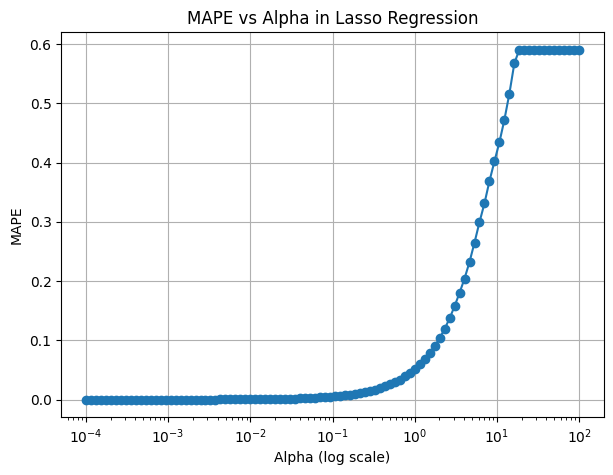

In [26]:
# Define dependent and independent variables
y_name = "Dependent_Var"
X_cols = [c for c in df.columns if c != y_name]

X = df[X_cols].values
y = df[y_name].values
# 2) Split dataset into training and test sets (50/50)
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples\n")

# ------------------------------------------------------
# 3) Standardize features before applying Lasso
#    (Lasso is sensitive to variable scale)
# ------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------------------------------
# 4) Run Lasso model with alpha = 1
# ------------------------------------------------------
lasso = Lasso(alpha=1, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# Extract coefficients
coef = pd.Series(lasso.coef_, index=X_cols)
print("Lasso coefficients with alpha=1:")
print(coef)
print()

# ------------------------------------------------------
# 5) Predict on test set and calculate MAPE
# ------------------------------------------------------
y_pred_test = lasso.predict(X_test_scaled)
mape_alpha1 = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"Mean Absolute Percentage Error (MAPE) with alpha=1: {mape_alpha1:.4f}\n")

# ------------------------------------------------------
# 6) Search for alpha that minimizes MAPE
# ------------------------------------------------------
alphas = np.logspace(-4, 2, 100)  # from 0.0001 to 100
mape_values = []

for a in alphas:
    model = Lasso(alpha=a, random_state=42, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_values.append(mape)

# Find alpha that minimizes MAPE
best_alpha = alphas[np.argmin(mape_values)]
best_mape = np.min(mape_values)

print(f"Best alpha value (minimizing MAPE): {best_alpha:.4f}")
print(f"Corresponding MAPE: {best_mape:.4f}\n")

# ------------------------------------------------------
# 7) Plot MAPE vs Alpha for visualization
# ------------------------------------------------------
plt.figure(figsize=(7,5))
plt.plot(alphas, mape_values, marker='o')
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("MAPE")
plt.title("MAPE vs Alpha in Lasso Regression")
plt.grid(True)
plt.show()


In [29]:

# 1) DATA
months = list(range(1, 26))
demand = [
    # Months 1-10
    100, 112, 107, 103,  91,  85,  84,  85,  79,  81,
    # Months 11-20
    134,  86,  99,  89, 111, 114, 118, 163, 193, 143,
    # Months 21-25
    144, 202, 158, 160, 144
]
advance = [
    # Months 1-10
     71,  30,  75,  64,  41,  51,  42,  51,  57,  49,
    # Months 11-20
    134,  52,  99,  56,  81,  79,  73, 163, 193,  99,
    # Months 21-25
     91, 202, 105, 101,  96
]

df = pd.DataFrame({"Month": months, "Demand": demand, "Advance": advance})

# ------------------------------------------------------
# 2) FEATURE ENGINEERING
#    - Use as much information as possible from the table:
#      Advance_t (current), Demand_{t-1,t-2}, Advance_{t-1,t-2}
#    - Lags ensure no future leakage for forecasting at time t.
# ------------------------------------------------------
df["Lag1_Demand"]  = df["Demand"].shift(1)
df["Lag2_Demand"]  = df["Demand"].shift(2)
df["Lag1_Advance"] = df["Advance"].shift(1)
df["Lag2_Advance"] = df["Advance"].shift(2)

# Drop first two rows that do not have full lag info
df_model = df.dropna().reset_index(drop=True)

feature_cols = ["Advance", "Lag1_Demand", "Lag2_Demand", "Lag1_Advance", "Lag2_Advance"]
target_col   = "Demand"

# ------------------------------------------------------
# 3) TRAIN / TEST SPLIT (chronological)
#    - Train: Months 1–20   -> in df_model these become indices 0..17
#    - Test : Months 21–25  -> in df_model these become the tail rows
# ------------------------------------------------------
# Map Month after lag-drop to keep chronology clear
train_mask = df_model["Month"] <= 20
test_mask  = df_model["Month"] >= 21

X_train = df_model.loc[train_mask, feature_cols].values
y_train = df_model.loc[train_mask, target_col].values
X_test  = df_model.loc[test_mask,  feature_cols].values
y_test  = df_model.loc[test_mask,  target_col].values
months_test = df_model.loc[test_mask, "Month"].tolist()

print(f"[Split] Train months: {df_model.loc[train_mask,'Month'].tolist()}")
print(f"[Split] Test  months: {months_test}\n")

# ------------------------------------------------------
# 4) STANDARDIZE FEATURES (fit on train only)
#    - Elastic Net expects comparable scales across features.
# ------------------------------------------------------
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# ------------------------------------------------------
# 5) TAILORED REGULARIZATION via per-feature multipliers
#    Idea:
#      - We "trust" current Advance_t as a leading indicator → penalize it LESS.
#      - Achieve this by *increasing its post-standardization scale*,
#        which reduces the effective coefficient penalty on that column.
#    Implementation:
#      - After standardization to unit variance, multiply selected columns:
#          Advance_t  × w_adv   (w_adv > 1 → less penalized)
#          Lags       × 1.0     (default penalty)
# ------------------------------------------------------
w_adv = 2.0   # less penalty on current Advance
w_lag = 1.0   # default penalty on lags

col_multipliers = np.array([w_adv, w_lag, w_lag, w_lag, w_lag], dtype=float)

X_train_reg = X_train_std * col_multipliers
X_test_reg  = X_test_std  * col_multipliers

# ------------------------------------------------------
# 6) HYPERPARAMETER SEARCH to minimize Test MAPE
#    - alpha ∈ [1e-4, 1e2], l1_ratio ∈ {0.2, 0.4, 0.6, 0.8, 1.0}
#    - Small dataset ⇒ keep grid compact to avoid overfitting the split.
# ------------------------------------------------------
alphas = np.logspace(-4, 2, 40)                  # 0.0001 ... 100
l1_grid = [0.2, 0.4, 0.6, 0.8, 1.0]               # mix of L1/L2
best = {"mape": np.inf, "alpha": None, "l1": None, "coef": None, "intercept": None}

for a in alphas:
    for l1 in l1_grid:
        model = ElasticNet(alpha=a, l1_ratio=l1, random_state=42, max_iter=10000)
        model.fit(X_train_reg, y_train)
        pred = model.predict(X_test_reg)
        mape = mean_absolute_percentage_error(y_test, pred)
        if mape < best["mape"]:
            best.update({
                "mape": mape, "alpha": a, "l1": l1,
                "coef": model.coef_.copy(), "intercept": float(model.intercept_)
            })

print(f"[Best Model] alpha={best['alpha']:.6f}, l1_ratio={best['l1']:.2f}")
print(f"[Best Model] Test MAPE = {best['mape']:.4f}")

# Fit once more with the best hyperparameters to get final predictions
best_model = ElasticNet(alpha=best["alpha"], l1_ratio=best["l1"],
                        random_state=42, max_iter=10000).fit(X_train_reg, y_train)
y_pred_test = best_model.predict(X_test_reg)

# ------------------------------------------------------
# 7) REPORT COEFFICIENTS (on the 'regularized-scaled' feature space)
#    If you want to compare relative importance, these are fine.
#    (Optionally, you could map them back by dividing by the multipliers
#     and the scaler's std; for ranking they are sufficient here.)
# ------------------------------------------------------
coef_series = pd.Series(best_model.coef_, index=feature_cols)
print("\n[Best Model] Coefficients (after tailored scaling):")
print(coef_series.round(4))

# ------------------------------------------------------
# 8) SHOW TEST PREDICTIONS vs ACTUALS (Month 21–25)
# ------------------------------------------------------
out = pd.DataFrame({
    "Month": months_test,
    "Actual_Demand": y_test,
    "Forecast": np.round(y_pred_test, 2),
    "APE(%)": np.round(100*np.abs(y_test - y_pred_test)/y_test, 2)
})
out["Cum_MAPE(%)"] = np.round(out["APE(%)"].expanding().mean(), 2)
print("\n[Test Forecasts (Month 21–25)]")
print(out.to_string(index=False))

# ------------------------------------------------------
# 9) QUICK INTERPRETATION HINTS (for your write-up)
# ------------------------------------------------------
print("\n=== Notes you can paste in your report ===")
print(f"- Features used: {feature_cols} (Advance_t prioritized via lighter penalty).")
print(f"- Train = Months 1–20; Test = Months 21–25 (chronological split).")
print(f"- Tailored regularization implemented with per-feature multipliers "
      f"(Advance_t × {w_adv}, lags × {w_lag}).")
print(f"- Best (alpha, l1_ratio) = ({best['alpha']:.6f}, {best['l1']:.2f}); "
      f"Test MAPE = {best['mape']:.4f}.")
print("- Coefficients suggest how current Advance and recent lags drive demand; "
      "zero (or near-zero) coefficients indicate features pruned by L1.")



[Split] Train months: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[Split] Test  months: [21, 22, 23, 24, 25]

[Best Model] alpha=0.000100, l1_ratio=1.00
[Best Model] Test MAPE = 0.0710

[Best Model] Coefficients (after tailored scaling):
Advance         12.5403
Lag1_Demand     12.5434
Lag2_Demand      1.5296
Lag1_Advance    -4.4484
Lag2_Advance    -2.3961
dtype: float64

[Test Forecasts (Month 21–25)]
 Month  Actual_Demand  Forecast  APE(%)  Cum_MAPE(%)
    21            144    125.71   12.70        12.70
    22            202    197.21    2.37         7.54
    23            158    152.61    3.41         6.16
    24            160    137.53   14.05         8.13
    25            144    139.71    2.98         7.10

=== Notes you can paste in your report ===
- Features used: ['Advance', 'Lag1_Demand', 'Lag2_Demand', 'Lag1_Advance', 'Lag2_Advance'] (Advance_t prioritized via lighter penalty).
- Train = Months 1–20; Test = Months 21–25 (chronological split).
- Tailore